In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import pathlib
import warnings
warnings.filterwarnings('ignore')
from audio_classification import *
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics 

import os
SR=22050

In [50]:
input_dir = '/home/mor/Downloads/'
train_df = pd.read_csv(input_dir+'train.csv')
# train1 = split_df(train_df)
# # test_df = pd.read_csv(input_dir+'test.csv').set_index('row_id')
# exmp_df = pd.DataFrame({'filename':['BLKFR-10-CPL_20190611_093000.pt540.mp3','ORANGE-7-CAP_20190606_093000.pt623.mp3'],
#                     'duration':[7*60+48,5*60+3],
#                     'ebird_code':['exemple','exemple']})
# expm1 = split_df(exmp_df)

In [60]:
train_df.ebird_code.value_counts().to_frame().query("ebird_code==100").count()

ebird_code    134
dtype: int64

In [80]:
df=pd.read_csv('train_full.csv')
df=df.dropna(subset=['amp_r','sc_r'])
len(df)

230111

# cluster

In [81]:
df.amp_r.quantile(np.arange(0,1.1,0.1))

0.0     0.000175
0.1     0.375815
0.2     0.586201
0.3     0.736318
0.4     0.850002
0.5     0.945202
0.6     1.031523
0.7     1.139970
0.8     1.305351
0.9     1.630039
1.0    28.246145
Name: amp_r, dtype: float64

In [82]:
df.sc_r.quantile(np.arange(0,1.1,0.1))

0.0    0.011602
0.1    0.041033
0.2    0.056545
0.3    0.070572
0.4    0.085107
0.5    0.101970
0.6    0.123565
0.7    0.155413
0.8    0.209677
0.9    0.318209
1.0    4.333633
Name: sc_r, dtype: float64

In [83]:

train_path = '/home/mor/Downloads/train_audio/'
#train_path = '/home/mor/Downloads/'

def add_train(train_df):
    train_df = train_df.sort_values(by='filename').reset_index()
    train_df['amp_r']=None
    train_df['sc_r']=None
    fle=''
    for ind, row in train_df.iterrows():
        if ind%100==0: print(ind)
        if row['filename']!=fle:
            fle=row['filename']
            try:
                audio_path = os.path.join(train_path, f"{row['ebird_code']}/{fle}")
                x , sr = librosa.load(audio_path,sr=SR)
                x_abs = np.abs(x)
                amp_mean = np.mean(x_abs)
            except:
                x = None
        if x is None:
            train_df.loc[ind,'amp_r'] = None
            train_df.loc[ind,'sc_r'] = None
            continue
        sec = int(row['seconds'])
        xx = x_abs[max(0,sr*(sec-5)):min(sr*sec,len(x))]
        sc = librosa.feature.spectral_centroid(xx, sr=sr)[0,:]
        train_df.loc[ind,'amp_r'] = np.mean(xx) / amp_mean
        train_df.loc[ind,'sc_r'] = np.std(sc) / np.mean(sc)
    return train_df

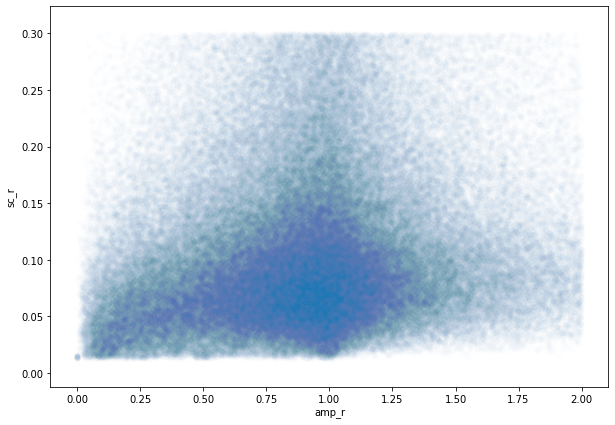

In [85]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot('amp_r','sc_r',data=df.query("amp_r<2 and sc_r<0.3"),alpha=0.01)

In [64]:
df.ebird_code.value_counts().to_frame().query("ebird_code>700").count()

ebird_code    164
dtype: int64

In [69]:
len(df)

230111

In [96]:
df1=df[(df.amp_r>1.5)|(df.sc_r>0.3)]
len(df1)

51918

In [98]:
df1.ebird_code.value_counts().to_frame().query("ebird_code>300").count()

ebird_code    59
dtype: int64

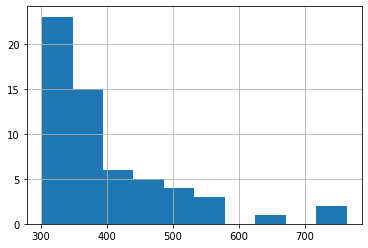

In [99]:
top=df1.ebird_code.value_counts().to_frame().query("ebird_code>300").index.values
df2 = df1[df1.ebird_code.isin(top)]
df2.ebird_code.value_counts().hist()

# Train

In [5]:
class TrainDataset():

    def __init__(self, path, df):
        self.path = path
        self.df = df.sort_values(by='filename')
        self.lables = sorted(df['ebird_code'].unique())
        self.num_rows = 40
        self.num_cols = int(SR*5/512)+1
        self.ds = tf.data.Dataset.from_generator(self.iter_train,
                                                 output_types=(tf.float32, tf.float32),
                                                 output_shapes = ((self.num_rows, self.num_cols,1), len(self.lables))
                                                )
    
    def size(self):
        return len(self.df)
    
    def get_lable_vec(self, bird):
        res = np.zeros(len(self.lables))
        res[self.lables.index(bird)]=1
        return res

    def iter_train(self):
        fle = ''
        for ind, row in self.df.iterrows():
            if row['filename'] != fle:
                fle = row['filename']
                audio_path = os.path.join(self.path, f"{row['ebird_code']}/{fle}")
                x, sr = librosa.load(audio_path, sr=SR)
            sec = row['seconds']
            xx = x[max(0, sr * (sec - 5)):min(sr * sec, len(x))]
            spec = librosa.feature.mfcc(y=xx, sr=SR, n_mfcc=40)
            for i in range(self.num_cols-spec.shape[1]):
                spec=np.concatenate([spec,spec[:,-1].reshape(spec.shape[0],1)],axis=1)
            l = self.get_lable_vec(row['ebird_code'])
            yield spec.reshape(spec.shape[0],spec.shape[1],1), l

            

In [60]:
df = pd.read_csv('train3lables.csv')
df = df[(df.amp_r>1.1)|(df.sc_r>0.15)]

In [61]:
#lables = train_df.ebird_code.value_counts().to_frame().query('ebird_code>=100').sample(3).index.values
# lables = ['wilfly' ,'indbun', 'greyel']
# print(lables)
# df = train1[train1.ebird_code.isin(lables)]
tr_df, ts_df = hash_split(df)
train = TrainDataset('/home/mor/Downloads/train_audio/',tr_df).ds.batch(32)
test = TrainDataset('/home/mor/Downloads/train_audio/',ts_df).ds.batch(32)
# print(len(tr_df))
# train

In [62]:
num_rows = 40
num_columns = 216

num_labels = 3

# Construct model 
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 215, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 107, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 107, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 106, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 53, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 53, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 52, 64)         8

In [4]:
train1 = train1.sort_values(by='filename')
len(train1)

230122

0
100


230000

In [64]:
#['wilfly', 'indbun', 'greyel'] df[(df.amp_r>1.1)|(df.sc_r>0.15)]
model.fit(train,epochs=9,validation_data=test)

Epoch 1/9
27/27 [==============================] - 682s 25s/step - loss: 1.6756 - accuracy: 0.4941 - val_loss: 0.9667 - val_accuracy: 0.6016
Epoch 2/9
27/27 [==============================] - 761s 28s/step - loss: 1.1109 - accuracy: 0.4870 - val_loss: 0.9646 - val_accuracy: 0.6172
Epoch 3/9
27/27 [==============================] - 644s 24s/step - loss: 1.0254 - accuracy: 0.5153 - val_loss: 0.9148 - val_accuracy: 0.5911
Epoch 4/9
27/27 [==============================] - 630s 23s/step - loss: 0.8968 - accuracy: 0.5979 - val_loss: 0.8811 - val_accuracy: 0.6198
Epoch 5/9
27/27 [==============================] - 599s 22s/step - loss: 0.8497 - accuracy: 0.6191 - val_loss: 0.8432 - val_accuracy: 0.6328
Epoch 6/9
27/27 [==============================] - 1235s 46s/step - loss: 0.8235 - accuracy: 0.6368 - val_loss: 0.8022 - val_accuracy: 0.6562
Epoch 7/9
27/27 [==============================] - 602s 22s/step - loss: 0.7970 - accuracy: 0.6474 - val_loss: 0.7891 - val_accuracy: 0.6745
Epoch 8/9
27

In [32]:
#['wilfly', 'indbun', 'greyel']
model.fit(train,epochs=9,validation_data=test)

Epoch 1/9
52/52 [==============================] - 645s 12s/step - loss: 1.4503 - accuracy: 0.3894 - val_loss: 1.0809 - val_accuracy: 0.4170
Epoch 2/9
52/52 [==============================] - 602s 12s/step - loss: 1.0869 - accuracy: 0.4250 - val_loss: 1.0675 - val_accuracy: 0.4296
Epoch 3/9
52/52 [==============================] - 592s 11s/step - loss: 1.0692 - accuracy: 0.4418 - val_loss: 1.0585 - val_accuracy: 0.4525
Epoch 4/9
52/52 [==============================] - 594s 11s/step - loss: 1.0312 - accuracy: 0.4702 - val_loss: 1.0453 - val_accuracy: 0.4548
Epoch 5/9
52/52 [==============================] - 591s 11s/step - loss: 1.0088 - accuracy: 0.4852 - val_loss: 1.0366 - val_accuracy: 0.4502
Epoch 6/9
52/52 [==============================] - 590s 11s/step - loss: 0.9823 - accuracy: 0.5045 - val_loss: 1.0266 - val_accuracy: 0.4513
Epoch 7/9
52/52 [==============================] - 591s 11s/step - loss: 0.9634 - accuracy: 0.5112 - val_loss: 1.0096 - val_accuracy: 0.4605
Epoch 8/9
52/

In [2]:
import os
train_path = '/home/mor/Downloads/train_audio/'
train_df = train1.head(20)
def iter_train():
    fle=''
    for ind, row in train_df.iterrows():
        if row['filename']!=fle:
            fle=row['filename']
            audio_path = os.path.join(train_path, f"{row['ebird_code']}/{fle}")
            x , sr = librosa.load(audio_path,sr=SR)
        sec = row['seconds']
        xx = x[max(0,sr*(sec-5)):min(sr*sec,len(x))]#, row['ebird_code']
        sc = librosa.feature.spectral_centroid(xx, sr=sr)[0,:]
        yield sc

#ds = tf.data.Dataset.from_generator(iter_train, output_types=(tf.float32,tf.string), output_shapes = ((SR*5),()))
#ds = tf.data.Dataset.from_generator(iter_train, output_types=tf.float32, output_shapes = (SR*5))
ds = tf.data.Dataset.from_generator(iter_train, output_types=tf.float32, output_shapes = (int(SR*5/512))+1)
ds

NameError: name 'train1' is not defined

In [57]:
ds = tf.data.Dataset.from_generator(
    iter_train, output_types=tf.float32, output_shapes = (), args=[train1.head(10),'/home/mor/Downloads/train_audio/'])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [34]:
t=tf.constant(x[0:50])

In [35]:
t.dtype

tf.float32

In [36]:
t

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([-4.7542999e-06, -4.9216701e-06,  1.6419474e-06, -9.4895410e-07,
        6.2216264e-07, -4.1450065e-07,  2.5801592e-07, -1.2567764e-07,
        3.4493115e-09,  1.1844712e-07, -2.4980818e-07,  4.0472619e-07,
       -6.1032540e-07,  9.3468867e-07, -1.6250574e-06,  4.9021646e-06,
        4.7761714e-06, -1.5055773e-06,  8.2829308e-07, -5.2372621e-07,
        3.4491708e-07, -2.2431011e-07,  1.3573755e-07, -6.6821791e-08,
        1.0866686e-08,  3.6120976e-08, -7.6698633e-08,  1.1258560e-07,
       -1.4496695e-07,  1.7465742e-07, -2.0219521e-07,  2.2789978e-07,
       -2.5191139e-07,  2.7422317e-07, -2.9470937e-07,  3.1315528e-07,
       -3.2928710e-07,  3.4280481e-07, -3.5341475e-07,  3.6086334e-07,
       -3.6496724e-07,  3.6564100e-07, -3.6292096e-07, -7.2724156e-06,
       -3.4813573e-07,  3.3685390e-07, -3.2373796e-07,  3.0951585e-07,
       -2.9502024e-07,  2.8116500e-07], dtype=float32)>

In [21]:
x[0:50]

array([-4.7542999e-06, -4.9216701e-06,  1.6419474e-06, -9.4895410e-07,
        6.2216264e-07, -4.1450065e-07,  2.5801592e-07, -1.2567764e-07,
        3.4493115e-09,  1.1844712e-07, -2.4980818e-07,  4.0472619e-07,
       -6.1032540e-07,  9.3468867e-07, -1.6250574e-06,  4.9021646e-06,
        4.7761714e-06, -1.5055773e-06,  8.2829308e-07, -5.2372621e-07,
        3.4491708e-07, -2.2431011e-07,  1.3573755e-07, -6.6821791e-08,
        1.0866686e-08,  3.6120976e-08, -7.6698633e-08,  1.1258560e-07,
       -1.4496695e-07,  1.7465742e-07, -2.0219521e-07,  2.2789978e-07,
       -2.5191139e-07,  2.7422317e-07, -2.9470937e-07,  3.1315528e-07,
       -3.2928710e-07,  3.4280481e-07, -3.5341475e-07,  3.6086334e-07,
       -3.6496724e-07,  3.6564100e-07, -3.6292096e-07, -7.2724156e-06,
       -3.4813573e-07,  3.3685390e-07, -3.2373796e-07,  3.0951585e-07,
       -2.9502024e-07,  2.8116500e-07], dtype=float32)

In [102]:
len(train)

21375

In [103]:
train.duration.describe()

count    21375.000000
mean        55.806784
std         76.385696
min          0.000000
25%         15.000000
50%         33.000000
75%         68.000000
max       2283.000000
Name: duration, dtype: float64

In [12]:
train.head()

rating playback_used ebird_code    channels        date          pitch  \
0     3.5            no     aldfly    1 (mono)  2013-05-25  Not specified   
1     4.0            no     aldfly  2 (stereo)  2013-05-27           both   
2     4.0            no     aldfly  2 (stereo)  2013-05-27           both   
3     3.5            no     aldfly  2 (stereo)  2013-05-27           both   
4     4.0            no     aldfly  2 (stereo)  2013-05-27           both   

   duration      filename          speed           species  ...  \
0        25  XC134874.mp3  Not specified  Alder Flycatcher  ...   
1        36  XC135454.mp3           both  Alder Flycatcher  ...   
2        39  XC135455.mp3           both  Alder Flycatcher  ...   
3        33  XC135456.mp3           both  Alder Flycatcher  ...   
4        36  XC135457.mp3          level  Alder Flycatcher  ...   

                                 url        country            author  \
0  https://www.xeno-canto.org/134874  United States  Jonathon Jongsma   
1  https://www.xeno-canto.org/135454  United States       Mike Nelson   
2  https://www.xeno-canto.org/135455  United States       Mike Nelson   
3  https://www.xeno-canto.org/135456  United States       Mike Nelson   
4  https://www.xeno-canto.org/135457  United States       Mike Nelson   

                        primary_label longitude         length   time  \
0  Empidonax alnorum_Alder Flycatcher   -92.962  Not specified   8:00   
1  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   
2  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   
3  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   
4  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   

          recordist                                            license  \
0  Jonathon Jongsma        Creative Commons Attribution-ShareAlike 3.0   
1       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...   
2       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...   
3       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...   
4       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...   

                       seconds  
0          [5, 10, 15, 20, 25]  
1  [5, 10, 15, 20, 25, 30, 35]  
2  [5, 10, 15, 20, 25, 30, 35]  
3      [5, 10, 15, 20, 25, 30]  
4  [5, 10, 15, 20, 25, 30, 35]  

[5 rows x 36 columns]

In [13]:
bird,file='aldfly','XC135457.mp3'
x , sr = librosa.load(f'/home/mor/Downloads/train_audio/{bird}/{file}')
ipd.Audio(x, rate=sr)

In [14]:
x.dtype

dtype('float32')

In [101]:
train.iloc[0]

rating                                                            3.5
playback_used                                                      no
ebird_code                                                     aldfly
channels                                                     1 (mono)
date                                                       2013-05-25
pitch                                                   Not specified
duration                                                           25
filename                                                 XC134874.mp3
speed                                                   Not specified
species                                              Alder Flycatcher
number_of_notes                                         Not specified
title                   XC134874 Alder Flycatcher (Empidonax alnorum)
secondary_labels    ['Empidonax minimus_Least Flycatcher', 'Leioth...
bird_seen                                                         yes
sci_name            

In [98]:
def run_test(dir):
    test.loc[:,'is_bird']=None
    fle=''
    for ind, row in test.iterrows():
        if row['audio_id']!=fle:
            fle=row['audio_id']
            audio_path = os.path.join(dir, fle+'.mp3')
            x , sr = librosa.load(audio_path)
        sec = row['seconds']
        xx = x[max(0,sr*(sec-5)):min(sr*sec,len(x))]
        sc = librosa.feature.spectral_centroid(xx, sr=sr)[0,:]
        print(xx.mean(),xx.max(),xx.std())
        print(sc.mean(),sc.max(),sc.std(),sc.std()/sc.mean())
        test.loc[ind,'is_bird'] = xx.max()>0.25 and sc.std()/sc.mean()>0.15

In [99]:
run_test()

In [97]:
test.is_bird

row_id
site_1_0a997dff022e3ad9744d4e7bbf923288_5     True
site_1_0a997dff022e3ad9744d4e7bbf923288_10    True
site_1_0a997dff022e3ad9744d4e7bbf923288_15    True
Name: is_bird, dtype: object

In [89]:
test['birds'] = np.where(test.is_bird,'nocall','redhea')

In [68]:
#audio_path = pathlib.Path('/home/mor/Downloads/ORANGE-7-CAP_20190606_093000.pt623.mp3')
#audio_path = pathlib.Path('/home/mor/Downloads/BLKFR-10-CPL_20190611_093000.pt540.mp3')
audio_path = '/home/mor/Downloads/test_audio/0a997dff022e3ad9744d4e7bbf923288.mp3'
x , sr = librosa.load(audio_path)
s5 = sr*5
ipd.Audio(audio_path)

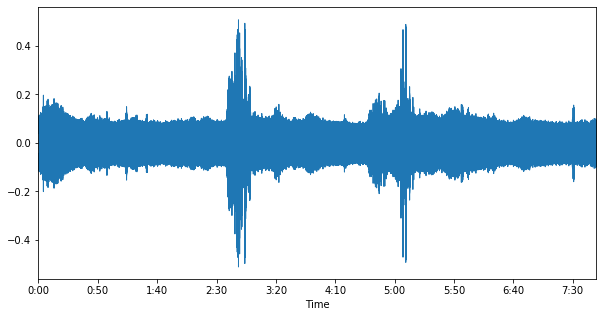

In [69]:
# Amplitude
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)

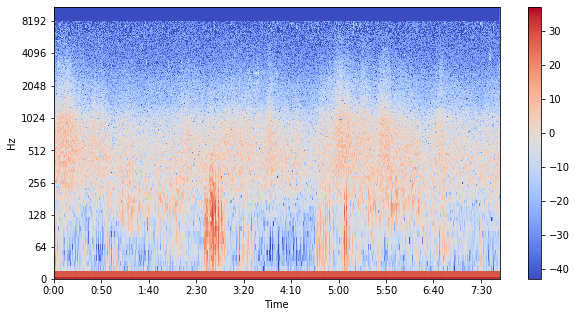

In [70]:
# Spectrogram
X = librosa.stft(x) #Fourier
Xdb = librosa.amplitude_to_db(abs(X)) 
plt.figure(figsize=(10, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

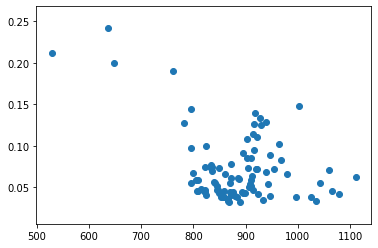

In [70]:
xx,sc={},{}
for i in range(int(len(x)/s5)):
    xx[i] = x[i*s5:(i+1)*s5]
    sc[i] = librosa.feature.spectral_centroid(xx[i], sr=sr)[0,:]
SC = pd.DataFrame(sc)
ST = SC.describe().T
ST['n_std'] = ST['std']/ST['mean']
plt.scatter(ST['mean'],ST['n_std'])

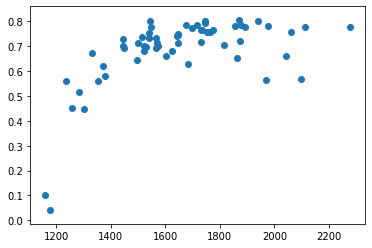

In [35]:
ST.sort_values(by='n_std')

count         mean          std          min          25%          50%  \
9   216.0  1174.880434    46.476980  1026.004735  1145.199999  1170.476520   
57  216.0  1159.235123   119.118130  1051.496121  1112.363627  1143.831939   
43  216.0  1302.969628   583.882354  1045.442427  1143.419136  1175.165600   
41  216.0  1255.451250   568.171837  1054.895306  1128.383537  1160.881471   
31  216.0  1281.846105   662.762516   965.507471  1094.852469  1149.985140   
..    ...          ...          ...          ...          ...          ...   
10  216.0  1746.059144  1396.786125  1058.814242  1140.760995  1179.152615   
5   216.0  1941.451585  1554.143139  1054.146319  1159.617090  1209.140303   
24  216.0  1744.044132  1397.274279   997.454846  1104.331186  1134.397021   
35  216.0  1544.206636  1239.245203   810.397661  1049.927615  1116.497015   
55  216.0  1871.937741  1510.345147   992.548051  1107.636027  1149.971197   

            75%          max     n_std  
9   1202.235713  1328.729414  0.039559  
57  1175.425276  2158.462856  0.102756  
43  1219.552733  5045.881845  0.448117  
41  1192.207784  5491.202275  0.452564  
31  1207.932591  5537.184173  0.517038  
..          ...          ...       ...  
10  1254.137880  6066.386807  0.799965  
5   1344.864245  6082.740217  0.800506  
24  1206.425227  5906.751097  0.801169  
35  1204.327656  6079.278977  0.802513  
55  1301.413622  6387.647530  0.806835  

[61 rows x 9 columns]

In [11]:
ipd.Audio(x[31*s5:35*s5],rate=sr)

In [12]:
ST.sort_values(by='n_std',ascending=False).head(15)

count         mean         std         min         25%         50%  \
34  216.0   635.651429  154.090923  326.233234  486.219743  640.359679   
33  216.0   528.728479  112.102100  339.356161  445.010578  502.749394   
32  216.0   647.756818  129.692162  371.106341  545.773473  650.749206   
35  216.0   761.216308  144.461653  461.128926  665.503009  753.865539   
92  216.0  1002.149775  147.829790  812.892541  889.141247  945.516878   
31  216.0   796.290556  114.939174  440.209263  787.760182  840.721630   
50  216.0   917.810136  127.845185  760.751148  850.001625  875.340104   
47  216.0   927.509083  123.528115  786.053197  852.963205  889.043763   
61  216.0   939.443472  121.321349  474.027828  897.781118  974.881733   
57  216.0   781.682566   99.582608  545.018876  718.297093  776.130236   
55  216.0   916.522774  115.424017  663.994577  843.375408  895.731169   
88  216.0   930.161877  116.648909  786.849868  856.962132  892.254438   
51  216.0   913.917148  104.170903  789.599632  856.098655  877.710772   
48  216.0   922.344147  102.575346  790.340173  851.774995  887.258336   
49  216.0   902.850697   98.178384  775.082063  846.304980  877.397253   

            75%          max     n_std  
34   770.092266  1010.364277  0.242414  
33   607.394113   840.406684  0.212022  
32   753.920445  1028.037036  0.200217  
35   860.389389  1413.286073  0.189777  
92  1088.824286  1506.809285  0.147513  
31   868.713709   952.262599  0.144343  
50   910.613112  1417.658547  0.139294  
47   950.731120  1419.480462  0.133183  
61  1021.047170  1148.948385  0.129142  
57   844.800908  1062.957113  0.127395  
55   976.116675  1276.861949  0.125937  
88   982.862112  1633.864659  0.125407  
51   922.223105  1373.001857  0.113983  
48   932.739144  1224.804970  0.111212  
49   911.466299  1325.280352  0.108743

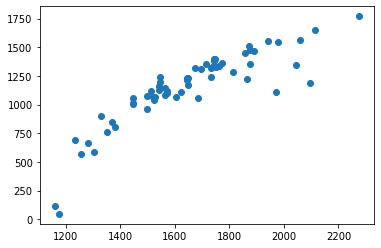

In [67]:
plt.scatter(SC.describe().T['mean'],SC.describe().T['std'])

In [91]:
# History

In [ ]:
# xx.max()>0.25 and sc.std()/sc.mean()>0.15 -> Nocall else 'redhea'